In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define time and space discretizations
xi = np.linspace ( -10 ,10 ,400) 
t = np.linspace (0 ,4*np.pi ,200)
dt = t[1] - t[0] ;
Xgrid ,T = np.meshgrid(xi ,t)

In [3]:
## Create two spatiotemporal patterns
f1 = np.reciprocal(np.cosh( Xgrid +3)) * (1* np.exp (1j*2.3* T))
f2 = np.reciprocal(np.cosh(Xgrid)) * np.tanh(Xgrid) * (2* np.exp (1j *2.8*T))

In [4]:
# combine signals and make data
f = f1+f2
X = f.T

In [5]:
Xgrid.shape

(200, 400)

In [18]:
f1.shape

(200, 400)

In [5]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

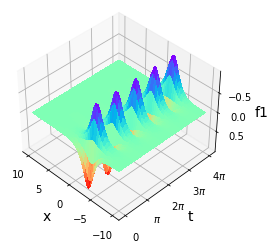

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid, T, np.real(f1), linewidth=0, antialiased=False,cmap="rainbow" )
# Set an equal aspect ratio
#ax.set_aspect("auto")

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_xlabel("x", size=14)
ax.set_ylabel("t", size=14)
ax.set_zlabel("f1", size=14)
ax.view_init(-140, 45)
plt.savefig("f1.png", dpi=600, facecolor="white", bbox_inches="tight")


In [62]:
%matplotlib inline

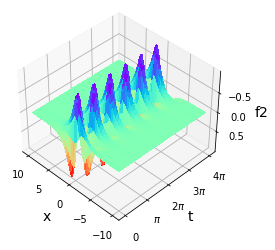

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid, T, np.real(f2), linewidth=0, antialiased=False,cmap="rainbow" )
# Set an equal aspect ratio
#ax.set_aspect("auto")

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_xlabel("x", size=14)
ax.set_ylabel("t", size=14)
ax.set_zlabel("f2", size=14)
ax.view_init(-140, 45)
plt.savefig("f2.png", dpi=600, facecolor="white", bbox_inches="tight")


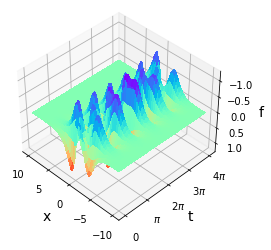

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid, T, np.real(f), linewidth=0, antialiased=False,cmap="rainbow" )
# Set an equal aspect ratio
#ax.set_aspect("auto")

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_xlabel("x", size=14)
ax.set_ylabel("t", size=14)
ax.set_zlabel("f", size=14)
ax.view_init(-140, 45)
plt.savefig("f.png", dpi=600, facecolor="white", bbox_inches="tight")


In [21]:
r=2

# Create DMD data matrices
# X1 = X, data matrix
# X2 = X’, shifted data matrix
X1 = X[:, :-1]# 1 to m-1
X2 = X[:, 1:] # 2 to m

## Perform singular value decomposition on X1
U, S, Vh = np.linalg.svd(X1, full_matrices = False)
# rank truncation
Ur = U[:, : r]
Sr = S[: r]
V = Vh.conj().T # Vh is conj transpose, we need V 
Vr = V[:, :r]


## Compute the Koopman matrix Atilde and DMD modes
# @ represents matrix multiplication
A_tilde = Ur.conj().T @ X2 @ (Vr*np.reciprocal(Sr))
## Perform eigenvalue decomposition on A_tilde
# returns eigvals and eigvectors
D, W = np.linalg.eig(A_tilde)
srt = np.argsort(D)[::-1] # indices of eigenvalues from largest to smallest
D = D[srt] # sorted eigenvalues
W = W[:, srt] # sorted eigenvectors

# DMD modes
Phi = X2 @ Vr @ np.diag(np.reciprocal(Sr)) @ W

## DMD Spectra
lamda = D#discrete -time eigenvalues
omega = np.round( np.diag(np.log(lamda))/dt, 4)# Continuos time eigenvalues



In [66]:
np.abs(omega)

array([[2.3, 0. ],
       [0. , 2.8]])

In [63]:
np.diag(np.reciprocal(Sr))

array([[0.00886633, 0.        ],
       [0.        , 0.01312369]])

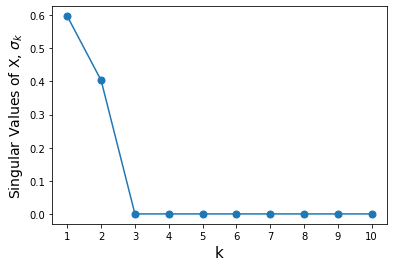

In [10]:
# plot of singular values 
plt.plot(range(1,11),S[:10]/sum(S),"-o", markersize=7)
plt.xlabel("k", size=15)
plt.ylabel("Singular Values of X, $\sigma_k$", size=14)
plt.xticks(range(1,11), range(1,11))
plt.savefig("sing_vals.png", dpi=600, facecolor="white", bbox_inches="tight")

plt.show()

In [22]:

## Compute DMD mode amplitudes b
x1 = X1[:, 0]
b = np.linalg.pinv(Phi)@x1#(Phi.T/ x1).T


time_dynamics = np.zeros((r, len(t)))
for i in range(len(t)):
    time_dynamics[:,i] = np.exp( omega*t[i])@b

Xdmd = Phi @ time_dynamics

/home/karan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


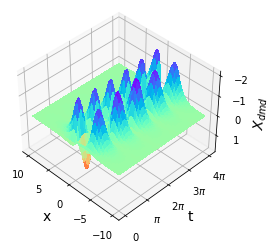

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid, T, np.real(Xdmd.T), linewidth=0, antialiased=False,cmap="rainbow" )
# Set an equal aspect ratio
#ax.set_aspect("auto")

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_xlabel("x", size=14)
ax.set_ylabel("t", size=14)
ax.set_zlabel("$X_{dmd}$", size=14)
ax.view_init(-140, 45)
plt.savefig("dmd_recons.png", dpi=600, facecolor="white", bbox_inches="tight")


# Spatial modes

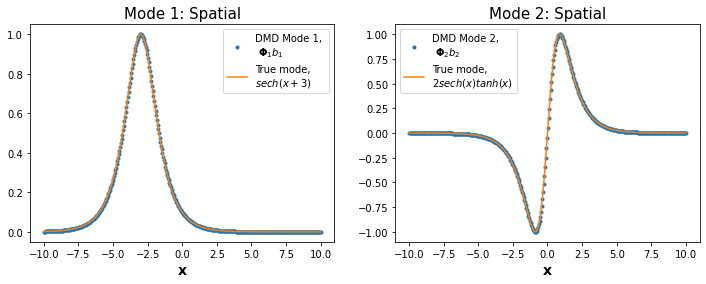

In [88]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(xi, np.real(Phi[:,0]*b[0]),".", label="DMD Mode 1, \n $\mathbf{\Phi}_1 b_1$")
true_spatial_mode1 = np.reciprocal(np.cosh( xi +3))

plt.plot(xi, np.real(true_spatial_mode1), label="True mode, \n$sech(x+3)$")
plt.legend(loc="best")
plt.xlabel("$\mathbf{x}$", size=14)
plt.title("Mode 1: Spatial", size=15)


plt.subplot(1,2,2)

plt.plot(xi, np.real(Phi[:,1]*b[1]),".", label="DMD Mode 2, \n $\mathbf{\Phi}_2 b_2$")
true_spatial_mode2 = 2*np.reciprocal(np.cosh(xi)) * np.tanh(xi)

plt.plot(xi, np.real(true_spatial_mode2), label="True mode, \n$2 sech(x) tanh(x)$")
plt.legend(loc="best")
plt.xlabel("$\mathbf{x}$", size=14)
plt.title("Mode 2: Spatial", size=15)
plt.savefig("spatial_modes.png", dpi=600, facecolor="white", bbox_inches="tight")


In [97]:
# Compute error
print("Error spatial mode 1: ",np.linalg.norm(np.real(Phi[:,0]*b[0])-np.real(true_spatial_mode1)))
print("Error spatial mode 2: ",np.linalg.norm(np.real(Phi[:,1]*b[1])-np.real(true_spatial_mode2)))


Error spatial mode 1:  6.410584013900943e-14
Error spatial mode 2:  6.312518602268008e-14


# Temporal modes

/home/karan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/karan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/karan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/karan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


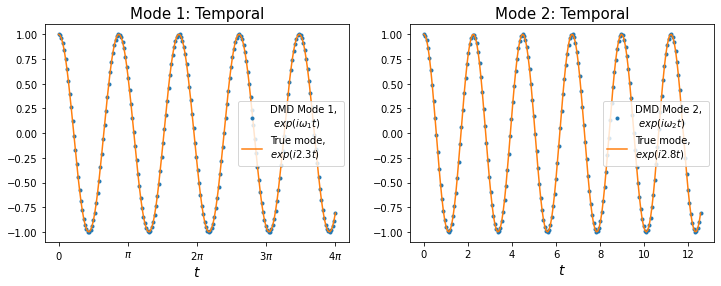

In [96]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(t,np.exp( omega[0,0]*t) ,".", label="DMD Mode 1, \n $exp(i\omega_1t)$")
true_temp_mode1 = np.exp (1j*2.3* t)

ax[0].plot(t, true_temp_mode1, label="True mode, \n$exp(i2.3t)$")
ax[0].legend(loc="best")
ax[0].set_xlabel("$t$", size=14)
ax[0].set_title("Mode 1: Temporal", size=15)
ax[0].xaxis.set_major_locator(plt.MultipleLocator(np.pi))
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))




ax[1].plot(t,np.exp( omega[1,1]*t) ,".", label="DMD Mode 2, \n $exp(i\omega_2t)$")
true_temp_mode2 = np.exp (1j*2.8* t)

ax[1].plot(t, true_temp_mode2, label="True mode, \n$exp(i2.8t)$")
ax[1].legend(loc="best")
ax[1].set_xlabel("$t$", size=14)
ax[1].set_title("Mode 2: Temporal", size=15)
plt.savefig("temporal_modes.png", dpi=600, facecolor="white", bbox_inches="tight")
